In [1]:
%pylab inline
import skimage.io
from scipy.ndimage.filters import convolve
from common.plotting import plot_mat
import theano
import theano.tensor.signal.downsample
import theano.tensor.shared_randomstreams


from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme
CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))
cifar10_train = CIFAR10(("train",), subset=slice(None,40000))
#this stream will shuffle the CIFAR10 set and return us batches of 100 examples
cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 25))                                             
cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))
# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(
    cifar10_validation, iteration_scheme=SequentialScheme(cifar10_validation.num_examples, 100))
cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(
    cifar10_test, iteration_scheme=SequentialScheme(cifar10_test.num_examples, 100))


print "The streams return batches containing %s" % (cifar10_train_stream.sources,)
print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Using gpu device 0: GeForce GTX 780 (CNMeM is enabled)
/home/i265983/Dokumenty/nn_assignments/libs/Theano/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Populating the interactive namespace from numpy and matplotlib
The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [2]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [3]:
class Layer(object):
    n = 1
    def __init__(self, rng=None):
        if rng == None:
            rng = numpy.random
        self.rng = rng
        self._parameters = []
        self.n = Layer.n
        Layer.n += 1
    
    @property
    def parameters(self):
        return self._parameters
    
    def fprop(self, X, learning_on):
        return X
    
    def name(self):
        return "Base layer"


class Conv(Layer):
    def __init__(self, num_in, num_out, filter_size=5, weight_init=None, bias_init=None, **kwargs):
        super(Conv, self).__init__(**kwargs)
        if weight_init == None:
            weight_init = IsotropicGaussian(0.05)
        if bias_init == None:
            bias_init = Constant(0.0)
        
        self.weight_init = weight_init
        self.bias_init = bias_init
        self.num_in = num_in
        self.num_out = num_out
        self.filter_size = filter_size
            
        self.W = theano.shared(np.zeros((self.num_out, self.num_in, self.filter_size, self.filter_size), dtype='float32'),
                               name='CW'+str(self.n))
        self.W.tag.initializer = self.weight_init
        self.B = theano.shared(np.zeros((self.num_out,), dtype='float32'),
                               name='CB'+str(self.n))
        self.B.tag.initializer = self.bias_init
        self._parameters = [self.W, self.B]
    
    def fprop(self, X, learning_on):
        return theano.tensor.nnet.conv2d(X, self.W, border_mode='full') + self.B.dimshuffle('x',0,'x','x')
    
    def name(self):
        return "Convolution layer (%d, %d, %d)" % (self.num_in, self.num_out, self.filter_size)

class ReLU(Layer):
    def __init__(self, **kwargs):
        super(ReLU, self).__init__(**kwargs)
    
    def fprop(self, X, learning_on):
        return theano.tensor.maximum(0.0, X)
    
    def name(self):
        return "ReLU layer"
    
class MaxPool(Layer):
    def __init__(self, filter_size=2, **kwargs):
        super(MaxPool, self).__init__(**kwargs)
        self.filter_size = filter_size
    
    def fprop(self, X, learning_on):
        return theano.tensor.signal.downsample.max_pool_2d(X, (self.filter_size, self.filter_size), ignore_border=True)
    
    def name(self):
        return "Max pooling layer (%d x %d)" % (self.filter_size, self.filter_size)
    

class Flatten(Layer):
    def __init__(self, dim, **kwargs):
        super(Flatten, self).__init__(**kwargs)
        self.dim = dim
    
    def fprop(self, X, learning_on):
        return X.flatten(self.dim)

    def name(self):
        return "Flatten layer (%d)" % (self.dim)
    
class Affine(Layer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(Affine, self).__init__(**kwargs)
        if weight_init == None:
            weight_init = IsotropicGaussian(std=2./np.sqrt(num_in))
        if bias_init == None:
            bias_init = Constant(0.0)
        
        self.weight_init = weight_init
        self.bias_init = bias_init
        self.num_in = num_in
        self.num_out = num_out
            
        self.W = theano.shared(np.zeros((self.num_in, self.num_out), dtype='float32'),
                               name='AW'+str(self.n))
        self.W.tag.initializer = self.weight_init
        self.B = theano.shared(np.zeros((self.num_out,), dtype='float32'),
                               name='AB'+str(self.n))
        self.B.tag.initializer = self.bias_init
        self._parameters = [self.W, self.B]
    
    def fprop(self, X, learning_on):
        return theano.tensor.dot(X, self.W) + self.B.dimshuffle('x',0)
    
    def name(self):
        return "Affine layer (%d, %d)" % (self.num_in, self.num_out)

    
class Dropout(Layer):
    """
    https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
    """
    def __init__(self, prob, **kwargs):
        super(Dropout, self).__init__(**kwargs)
        self.prob = prob
        self.rng = theano.tensor.shared_randomstreams.RandomStreams()
    
    def fprop(self, X, learning_on):
        tmp = self.rng.uniform(X.shape) >= self.prob
        return theano.tensor.switch(learning_on,
                                    X * tmp / (1 - self.prob),
                                    X)
    
    def name(self):
        return "Dropout layer (%f)" % self.prob
    
class SoftMax(Layer):
    def __init__(self, **kwargs):
        super(SoftMax, self).__init__(**kwargs)
    
    def fprop(self, X, learning_on):
        return theano.tensor.nnet.softmax(X)
    
    def name(self):
        return "Softmax layer"

    
class Predict(Layer):
    def __init__(self, **kwargs):
        super(Predict, self).__init__(**kwargs)
    
    def fprop(self, X, learning_on):
        return theano.tensor.argmax(X, axis=1)
    
    def name(self):
        return "Prediction layer"

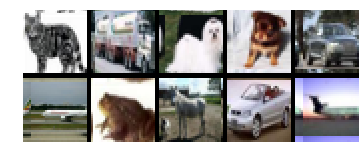

In [4]:
class Transform(object):
    def __init__(self, rng=None):
        if rng == None:
            rng = numpy.random
        self.rng = rng
    
    def transform(self, X):
        return X
    
    def name(self):
        return "Identity transformation"

class Shift(Transform):
    def __init__(self, shift_size=4, **kwargs):
        super(Shift, self).__init__(**kwargs)
        self.shift_size = shift_size
        
    def transform(self, X):
        res = X
        for i in xrange(res.shape[0]):
            res[i] = np.roll(res[i], self.rng.randint(-self.shift_size, self.shift_size + 1), axis=1)
            res[i] = np.roll(res[i], self.rng.randint(-self.shift_size, self.shift_size + 1), axis=2)
        return res
    
    def name(self):
        return "Random shift by %d" % self.shift.size
    
trans = [trans() for trans in Transform.__subclasses__()]
def random_transform(X_batch):
    global trans
    return trans[np.random.randint(0, len(trans))].transform(X_batch)

# example of transformation
for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator():
    X = X_batch
    break
X = random_transform(X[:10])
plot_mat(X, cmap='gray')

In [5]:
class FeedForwardNet(object):
    def __init__(self, layers=None):
        if layers == None:
            layers = []
        self.layers = layers
        self.log_probs = None
        self.predictions = None
        self.error_rate = None
        self.nll = None
        self.weight_decay = None
        self.cost = None
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    def initialize(self, X, learning_on, wdec_const):
        theano.config.compute_test_value = 'off'
        
        for layer in self.layers:
            X = layer.fprop(X, learning_on)
        
        self.log_probs = theano.tensor.nnet.softmax(X)
        self.predictions = theano.tensor.argmax(self.log_probs, axis=1)
        self.error_rate = theano.tensor.neq(self.predictions,Y.ravel()).mean()
        self.nll = - theano.tensor.log(self.log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()
        self.weight_decay = 0.0
        for p in self.parameters:
            if p.name[1]=='W':
                self.weight_decay = self.weight_decay + wdec_const * (p**2).sum()
        self.cost = self.nll + self.weight_decay

In [6]:
# X is batch_size x num_channels x img_rows x img_columns
X = theano.tensor.tensor4('X')
Y = theano.tensor.matrix('Y', dtype='uint8')
X_test_value, Y_test_value = next(cifar10_train_stream.get_epoch_iterator())
X.tag.test_value = X_test_value[:3]
Y.tag.test_value = Y_test_value[:3]
learning_on = theano.tensor.lscalar('learning_on')

net = FeedForwardNet(layers=[
        Conv(3,  50,  filter_size=5),  ReLU(), MaxPool(2), Dropout(0.2),
        Conv(50, 100, filter_size=5),  ReLU(), MaxPool(2), Dropout(0.2),
        Flatten(2),
        Affine(100*11*11, 500), ReLU(), Dropout(0.5),
        Affine(500, 500),       ReLU(), Dropout(0.5),
        Affine(500, 100),       ReLU(), Dropout(0.5),
        Affine(100, 10)
    ])

net.initialize(X, learning_on, wdec_const=2e-3)

In [7]:
# The updates will update our shared values
updates = []

lrate = theano.tensor.scalar('lrate',dtype='float32')
momentum = theano.tensor.scalar('momentum',dtype='float32')


# Theano will compute the gradients for us
gradients = theano.grad(net.cost, net.parameters)

#initialize storage for momentum
velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in net.parameters]

for p,g,v in zip(net.parameters, gradients, velocities):
    v_new = momentum * v - lrate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]

In [8]:
#compile theano functions

#each call to train step will make one SGD step
train_step = theano.function([X,Y,lrate,momentum,learning_on],
                             [net.cost, net.error_rate, net.nll, net.weight_decay],
                             updates=updates)
#each call to predict will return predictions on a batch of data
predict = theano.function([X,learning_on], net.predictions)

In [9]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X, 0)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples


#utilities to save values of parameters and to load them

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in net.parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in net.parameters]

def load_parameters(snapshot):
    for p, s in zip(net.parameters, snapshot):
        p.set_value(s, borrow=False)

Learning started at 21:37:12
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
After epoch 1, took 79.8222s
valid_err_rate:          48.240000% currently going to do 3 epochs
averaged train_err_rate: 60.617500% averaged train nll: 1.649031 averaged train loss: 7.150473
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
After epoch 2, took 79.5008s
valid_err_rate:          45.520000% currently going to do 6 epochs
averaged train_err_rate: 49.087500% averaged train nll: 1.358639 averaged train loss: 3.068937
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
After epoch 3, took 79.6221s
valid_err_rate:          39.820000% currently going to do 8 epochs
averaged train_err_rate: 44.037500% averaged train nll: 1.237807 averaged train loss: 1.942275
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
After epoch 4, took 79.8575s
valid_err_rate:          36.530000% currently

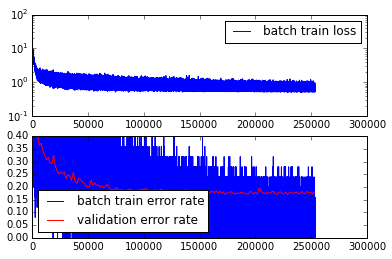

In [10]:
from datetime import datetime
import pickle
import time

# init training
i=0
e=0

init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 2.5

base_lrate = 1e-2
K = 10000
momentum=0.9

# training loop
try:
    print "Learning started at %02d:%02d:%02d" % (datetime.now().hour, datetime.now().minute, datetime.now().second)
    while e<number_of_epochs: #This loop goes over epochs
        e += 1
        #First train on all data from this batch
        epoch_start_i = i
        start_time = time.time()
        for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator(): 
            i += 1
            lrate = base_lrate * K / np.maximum(K, i)

            X_batch = random_transform(X_batch)
            L, err_rate, nll, wdec = train_step(X_batch, Y_batch, lrate, momentum, 0) # DROPOUT OFF

            train_loss.append((i,L))
            train_erros.append((i,err_rate))
            train_nll.append((i,nll))
            if i % 40 == 0:
                print '.',
            
        # After an epoch compute validation error
        val_error_rate = compute_error_rate(cifar10_validation_stream)
        if val_error_rate < best_valid_error_rate:
            number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
            best_valid_error_rate = val_error_rate
            best_params = snapshot_parameters()
            best_params_epoch = e
            pickle.dump(best_params, open('Conv2.pkl', 'w'))
            pickle.dump(e, open('Conv2_e.pkl', 'w'))
            pickle.dump(i, open('Conv2_i.pkl', 'w'))
            pickle.dump(number_of_epochs, open('Conv2_number_of_epochs.pkl', 'w'))

        validation_errors.append((i,val_error_rate))
        print "\nAfter epoch %d, took %.4fs" % (e, time.time() - start_time)
        print "valid_err_rate:          %f%% currently going to do %d epochs" %(
            val_error_rate*100, number_of_epochs)
        print "averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
            np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
            np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
            np.mean(np.asarray(train_loss)[epoch_start_i:,1]))
except KeyboardInterrupt:
    print "\nKeyboard interruption, user stopped learning"


print "Setting network parameters from after epoch %d" %(best_params_epoch)
load_parameters(best_params)

print "Learning ended at %02d:%02d:%02d" % (datetime.now().hour,
                                            datetime.now().minute,
                                            datetime.now().second)

print "Test error rate: %f" % (compute_error_rate(cifar10_test_stream), )

subplot(2,1,1)
train_loss = np.array(train_loss)
semilogy(train_loss[:,0], train_loss[:,1], label='batch train loss')
legend()

subplot(2,1,2)
train_erros = np.array(train_erros)
plot(train_erros[:,0], train_erros[:,1], label='batch train error rate')
validation_errors = np.array(validation_errors)
plot(validation_errors[:,0], validation_errors[:,1], label='validation error rate', color='r')
ylim(0,0.4)
legend(loc='lower left')